In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from tensorflow.keras import layers

tf.device("GPU")


2024-05-10 11:25:14.592959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 11:25:14.597806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 11:25:14.598037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ion/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 11:25:14.675753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 11:25:14.675971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 11:25:14.676158: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5665 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


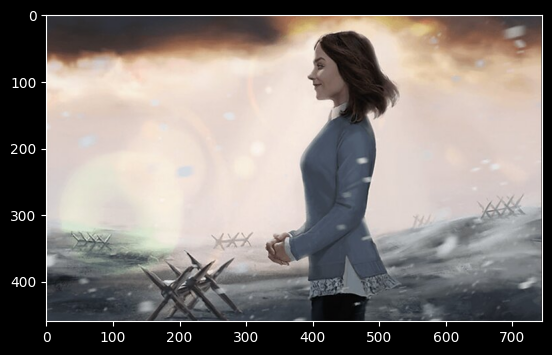

In [2]:
test_image = cv2.imread("../../data/art/ffd2cb24-311f-4411-8f17-c481caf132c2.jpg")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))


In [3]:
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../../data/art', label_mode = None, 
    image_size = (64, 64), batch_size = batch_size,
)

train_dataset = train_dataset.map(lambda x: (x / 127.5) - 1)

TypeError: Unknown keywords argument(s): ('verbose',)

2024-05-08 20:12:01.499611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


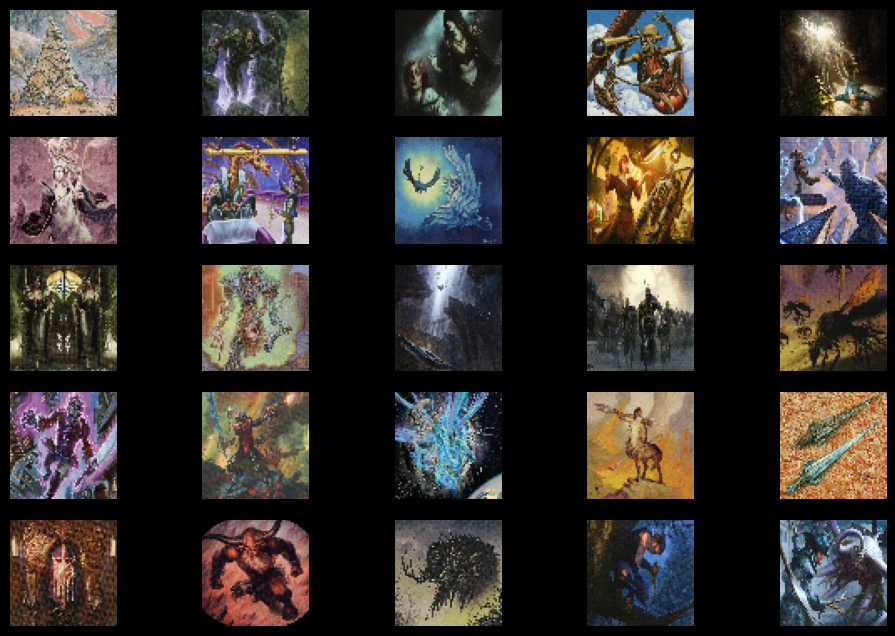

In [ ]:
plt.figure(figsize = (12, 8))

for images in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow((images[i].numpy()+1)/2)
        plt.axis('off')


In [ ]:
init_weights_kernel = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

In [ ]:
def generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape = (100, )))
    model.add(layers.Dense(4 * 4 * 256))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 256)))
    
    model.add(layers.Conv2DTranspose(128, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel , use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(32, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size = 4, padding = 'same', strides = 2, activation = 'tanh',
                                     kernel_initializer = init_weights_kernel, use_bias = False))
   
    
    return model

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 2, input_shape = (64, 64, 3), padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False ))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.ZeroPadding2D(padding = ((0, 1), (0, 1))))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, kernel_size = 3, strides=1, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss


In [ ]:
generator = generator_model()
discriminator = discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


/home/kevin/repos/mtg-ml/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/kevin/repos/mtg-ml/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [ ]:
def generate_and_plot_images(model, epoch, test_input):
  
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)  
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))


In [ ]:
def train(dataset, epochs):
    
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list = []
    fake_score_list = []

    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')
        
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
        
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
           
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f,\
               real_score %.2f%%, fake_score %.2f%%'  %
              (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)                 

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list


In [ ]:
import contextlib
@contextlib.contextmanager
def options(options):
  old_opts = tf.config.optimizer.get_experimental_options()
  tf.config.optimizer.set_experimental_options(options)
  try:
    yield
  finally:
    tf.config.optimizer.set_experimental_options(old_opts)


In [ ]:
with options({"layout_optimizer": False}):
    gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)


  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 1122 batches..


: 